In [1]:
import networkx as nx
import numpy as np
import pickle
import os, random
import itertools
from env.utils import save_dag, load_dag, to_pickle, visualize_dag
from env.utils import *
import matplotlib.pyplot as plt


### DAG generation

|Parameters | Notes |
| :- | :- |
|v |number of nodes in the graph |
|alpha|shape parameter (depth ~ sqrt(v)/alpha)|
|seed|random seed|
|conn_prob|graph density parameter (# of edges ~ conn_prob)|

In [2]:
def graph_dag_structure(v,
                      alpha,
                      seed,
                      conn_prob=0.1,
                      visualize = False):
    np.random.seed(seed)

    height_mean = np.sqrt(v) / alpha
    height = int(np.ceil(np.random.uniform(height_mean*0.8, height_mean*1.2)))

    width_mean = alpha * np.sqrt(v)
    widths = []

    for i in range(height):
        widths.append(int(np.ceil(np.random.uniform(0, 2 * width_mean))))

    total_operator = sum(widths)

    G = nx.DiGraph()
    G.add_node(0)
    cnt = 1
    nodes = [[] for i in range(height + 2)]
    nodes[0].append(0)
    for i in range(height):
        for j in range(widths[i]):
            nodes[i+1].append(cnt)
            G.add_node(cnt)
            for k in set().union(*nodes[:i+1]):
                if np.random.rand() < conn_prob:
                    G.add_edge(k, cnt)
            cnt += 1
        

    nodes[-1].append(total_operator + 1)
    G.add_node(total_operator + 1)

    #make sure the depth equals height
    critical_path = [random.choice(n) for n in nodes]
    for x,y in zip(critical_path, critical_path[1:]):
        G.add_edge(x, y)
        
    # Validity checking, if any node in the middle has 0 indegree or 0 outdegree,
    # randomly connect
    for i, layer in enumerate(nodes):
        if i > 0 and i < height + 1:
            for node in layer:
                if G.out_degree(node) == 0:
                    G.add_edge(node, random.choice([a for n in nodes[i+1:] for a in n]))
                if G.in_degree(node) == 0:
                    G.add_edge(random.choice([a for n in nodes[:i] for a in n]), node)


    if visualize:
        visualize_dag(G, widths, height)
        
    widths.insert(0, 1)
    widths.append(1)
    height += 2
    return G, widths, height

### Single data generation

|Program Graph Parameters | Notes |
| :- | :- |
|v |number of nodes in the graph |
|alpha|shape parameter (depth ~ sqrt(v)/alpha)|
|seed|random seed|
|conn_prob|graph density parameter (# of edges ~ conn_prob)|
|num_types|number of different types of hardware availbility constraint (for placement)|
|avg_compute|the average compute required for each op in the graph|
|avg_bytes|the average data bytes to be transferred for each edge in the graph|
|b_comp|op heterogenity parameter |
|b_comm|data link heterogeneity parameter|

#### Output: networkx.DiGraph()
+ node data: dict
  + \'compute\': the amount of compute required for the operator
  + \'h_constraint\': the specific hardware type required for running the operator
+ edge data: dict
  + \'bytes\': the amount of data to be transferred between pairs of operators with data dependency

|Network Parameters | Notes |
| :- | :- |
|n_devices |number of devices |
|seed|random seed|
|num_types|number of different types of hardware availbility constraint (for placement)|
|type_prob|placement constraint parameter (available devices ~ type_prob|
|avg_speed|the average compute speed of devices in the network|
|avg_bw|the average communication bw between devices in the network|
|avg_delay|the average communication delay between devices in the network|
|b_bw|device heterogenity parameter (variance of compute speed)|
|b_speed|communication link heterogeneity parameter (variance of communication speed)|

#### Output: dict
+ \'delay\': np array of size (n_devices, n_devices). (i,j) indexes the communication delay between device i and device j 
+ \'comm_speed\': np array of size (n_devices, n_devices). (i,j) indexes the 1/communication_bw between device i and device j 
+ \'speed\': np array of size (n_devices, ). i indexes the computation speed of device i 
+ \'device_constraints\': list of lists. i indexes the list of available hardware types of device i 

##### NOTES on latency cost:
+ computation latency = compute (program node) / speed (network)
+ communication latency = bytes (program edge) * comm_speed (network) + delay (network)


##### NOTES on placement constraints: 
+ _num_types_ for program is used to model different hardware requirements for each operator. Each node in the generated program will be assigned 1 hardware requirement out of _num_types_. 
+ _num_types_ for network is used to model different hardware availbility on each device. Each device in the network will have each type of hardware availabile with probability _type_prob_. For a given hardware type, the number of devices in the network that has this type available is propotional to _type_prob_.
+ Each operator can only be placed on a device that has the hardware requirement type available on it. 
+ _num_types_ for network/program generation should __match__. Otherwise, either will be ignored or some operators may not have any feasible devices for placement. 

In [3]:
def generate_graph(alpha,
                        v,
                        connect_prob,
                        seed,
                        num_types,
                        avg_compute,
                        avg_bytes,
                        b_comp=0.2,
                        b_comm=0.2):
    
    
    
    G, widths, height = graph_dag_structure(v,alpha, seed, connect_prob)
    np.random.seed(seed)


    # compute requirement for each dag node
    for n in G.nodes:
        G.nodes[n]['compute'] = np.random.uniform(avg_compute * (1-b_comp/2), avg_compute * (1+b_comp/2))
        G.nodes[n]['h_constraint'] = np.random.choice(range(num_types))
    
    # Communication requirement (bytes) for each dag edge
    for edge in G.edges:
        G.edges[edge]['bytes'] = np.random.uniform(avg_bytes * (1-b_comm/2), avg_bytes * (1+b_comm/2))
    
    G.graph['alpha'] = alpha
    G.graph['v'] = v
    G.graph['seed'] = seed
    G.graph['num_types'] = num_types
    G.graph['avg_compute'] = avg_compute
    G.graph['avg_bytes'] = avg_bytes
    G.graph['b_comp'] = b_comp
    G.graph['b_comm'] = b_comm
    
    return G

def generate_network(n_devices, 
                     seed,
                     num_types=5,
                     type_prob=0.3,
                     avg_speed=3,
                     avg_bw= 200,
                     avg_delay= 10, 
                     b_bw=0.2,
                     b_speed=0.2
                     ):

    
    delay = np.random.uniform(0, 2 * avg_delay, (n_devices, n_devices))
    avg_comm = 1/avg_bw
    comm_speed = np.random.uniform(avg_comm * (1-b_bw/2), avg_comm * (1+b_bw/2), (n_devices, n_devices))
    for i in range(n_devices):
        for j in range(i, n_devices):
            if i == j:
                delay[i][j] = 0
                comm_speed[i][j] = 0
            else:
                delay[i][j] = delay[j][i]
                comm_speed[i][j] = comm_speed[j][i]
         
                
    # speed for each device
    speed = np.random.uniform(avg_speed * (1-b_speed/2), avg_speed * (1+b_speed/2), n_devices)
    
    device_constraints = {}
    
    for i in range(n_devices):
        device_constraints[i] = []
        for j in range(num_types):
            if np.random.rand() < type_prob:
                device_constraints[i].append(j)
        if len(device_constraints[i]) == 0:
            device_constraints[i].append(np.random.choice(range(num_types)))
            
    network = {}
    network["delay"] = delay
    network["comm_speed"] = comm_speed
    network["speed"] = speed
    network["device_constraints"] = device_constraints
    
    network['n_devices'] = n_devices
    network["seed"] = seed
    network["num_types"] = num_types
    network["type_prob"] = type_prob
    network["avg_speed"] = avg_speed
    network['avg_bw'] = avg_bw
    network['avg_delay'] = avg_delay
    network["b_bw"] = b_bw
    network['b_speed'] = b_speed
    
    return network


### Batch data generation

+ _generate_networks_: input lists of each parameter and generate 25 (by default) networks for each combination of the parameters
  + output dict: parameter string --> list of _number_(25)  network dicts (generated by _generate_network_)

+ _generate_programs_: input list of each program parameters and generate 25 (by default) program graphs for each combination of parameters
  + output dict: parameter string --> list of _number_(25) program graphs (generated by _generate_program_)

+ Default _num_type = 5_

In [4]:
def generate_networks(n_devices, 
                     type_probs,
                     avg_speeds,
                     avg_bws,
                     avg_delays, 
                     b_bws,
                     b_speeds, 
                     number=25,
                     num_type=5):
    res = {}
    network_path = "./data/device_networks"
    if not os.path.exists(network_path):
        os.mkdir(network_path)
    for n in n_devices:
        for p in type_probs:
            for avg_speed in avg_speeds:
                for avg_bw in avg_bws:
                    for avg_delay in avg_delays:
                        for b_bw in b_bws:
                            for b_speed in b_speeds:
                                networks = []
                                for seed in range(number):
                                    network = generate_network(n,seed,num_type,p,avg_speed,avg_bw,avg_delay,b_bw,b_speed)
                                    networks.append(network)
                                network_fn = f"ndevice_{n}_ntype_{num_type}_speed_{avg_speed}_bw_{avg_bw}_delay_{avg_delay}_tprob_{p}_bbw_{b_bw}_bspeed_{b_speed}.pkl"
                                network_save_path = os.path.join(network_path, network_fn)
                                to_pickle(network_save_path, networks)
                                res[network_fn] = networks
    return res

def generate_programs(alphas,
                        vs,
                        connect_probs,
                        avg_computes,
                        avg_bytes,
                        b_comps,
                        b_comms,
                        number=25,
                        num_types=5):
    res = {}
    op_path = "./data/op_networks/"
    if not os.path.exists(op_path):
        os.mkdir(op_path)
    for alpha in alphas:
        for v in vs:
            for p in connect_probs:
                for avg_compute in avg_computes:
                    for avg_byte in avg_bytes:
                        for b_comp in b_comps:
                            for b_comm in b_comms:
                                programs = []
                                for seed in range(number):
                                    G = generate_graph(alpha,v,p,seed,num_types,avg_compute,avg_byte,b_comp,b_comm)
                                    programs.append(G)
                                op_fn = f"v_{v}_alpha_{alpha}_connp_{p}_ntype_{num_types}_compute_{avg_compute}_bytes_{avg_byte}_bcomp_{b_comp}_bcomm_{b_comm}.pkl"
                                op_fn = os.path.join(op_path, op_fn)
                                to_pickle(op_fn, programs)
                                res[op_fn] = programs
    return res
    


##### Full data generation
The full sets of parameters used for data generation. 

__Don't run this block, it takes a long time__

In [ ]:
n_devices = [10, 20, 50, 100]
type_probs = [0.1, 0.2, 0.4, 0.6]
avg_speeds = [5]
avg_bws = [100]
avg_delays = [10]
b_bws = [0.2, 0.5, 0.8]
b_speeds = [0.2, 0.5, 0.8 ]

vs = [10, 20, 40, 60, 80, 100]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10]
connect_probs = [0.1, 0.2, 0.4, 0.8]
avg_computes = [5, 50, 100]
avg_bytes = [100, 1000, 10000]
b_comps = [0.2, 0.5, 0.8]
b_comms = [0.2, 0.5, 0.8]

networks = generate_networks(n_devices, type_probs, avg_speeds, avg_bws, avg_delays, b_bws, b_speeds, 25)
programs = generate_programs(alphas, vs, connect_probs, avg_computes, avg_bytes, b_comps, b_comms, 25)

#### Subset data generation/manipulation
+ calculate the expected communication cost and computation cost given parameters
+ calculate the average communication cost of each edge and average computation cost of each node for each sampled network/program pair
+ ccr: communication to computation ratio


Average comp 5    , comp speed 5    , comm bytes: 100  , comm bw: 100  , comm delay: 10   
Expected comm cost:  11.000, comp cost: 1.000, ccr: 11.000
Empirical comm cost: 10.970, comp cost: 1.004, ccr: 10.925


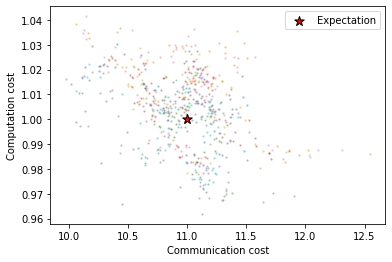

Average comp 5    , comp speed 5    , comm bytes: 1000 , comm bw: 100  , comm delay: 10   
Expected comm cost:  20.000, comp cost: 1.000, ccr: 20.000
Empirical comm cost: 19.982, comp cost: 1.004, ccr: 19.900


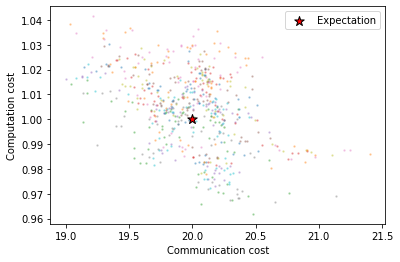

Average comp 5    , comp speed 5    , comm bytes: 10000, comm bw: 100  , comm delay: 10   
Expected comm cost:  110.000, comp cost: 1.000, ccr: 110.000
Empirical comm cost: 110.096, comp cost: 1.004, ccr: 109.646


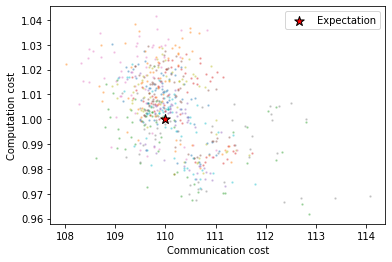

Average comp 100  , comp speed 5    , comm bytes: 100  , comm bw: 100  , comm delay: 10   
Expected comm cost:  11.000, comp cost: 20.000, ccr: 0.550
Empirical comm cost: 10.970, comp cost: 20.082, ccr: 0.546


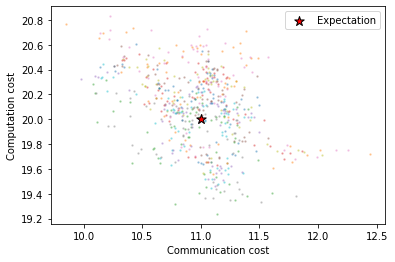

Average comp 100  , comp speed 5    , comm bytes: 1000 , comm bw: 100  , comm delay: 10   
Expected comm cost:  20.000, comp cost: 20.000, ccr: 1.000
Empirical comm cost: 19.980, comp cost: 20.082, ccr: 0.995


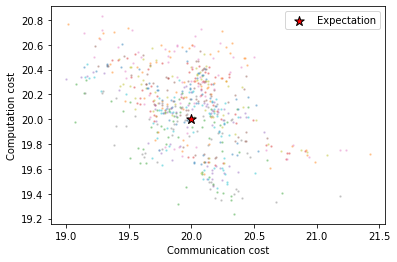

Average comp 100  , comp speed 5    , comm bytes: 10000, comm bw: 100  , comm delay: 10   
Expected comm cost:  110.000, comp cost: 20.000, ccr: 5.500
Empirical comm cost: 110.108, comp cost: 20.082, ccr: 5.483


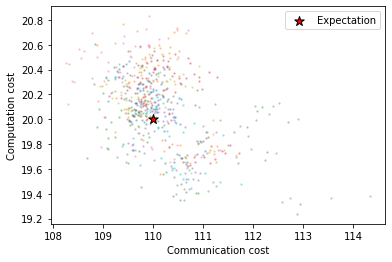

In [12]:
import itertools

n_devices = [20,30]
type_probs = [0.2]
avg_speeds = [5]
avg_bws = [100]
avg_delays = [10]
b_bws = [0.2]
b_speeds = [0.2]

vs = [20, 30, 50]
alphas = [0.1, 0.5, 1.0, 2.0]
connect_probs = [0.2]
avg_computes = [5, 100]
avg_bytes = [100, 1000, 10000]
b_comps = [0.2]
b_comms = [0.2]

networks = generate_networks(n_devices, type_probs, avg_speeds, avg_bws, avg_delays, b_bws, b_speeds, 5)
programs = generate_programs(alphas, vs, connect_probs, avg_computes, avg_bytes, b_comps, b_comms, 5)

for speed in avg_speeds:
    for bw in avg_bws:
        for delay in avg_delays:
            for speed in avg_speeds:
                for compute in avg_computes:
                    for b in avg_bytes:
                        print(f'Average comp {compute: <5d}, comp speed {speed: <5d}, comm bytes: {b: <5d}, comm bw: {bw:<5d}, comm delay: {delay:<5d}')
                        net_filter = f'speed_{speed}_bw_{bw}_delay_{delay}_'
                        app_filter = f'compute_{compute}_bytes_{b}_'
                        nets = [d for k in filter(lambda elem: net_filter in elem[0], networks.items()) for d in k[1]]
                        apps = [d for k in filter(lambda elem: app_filter in elem[0], programs.items()) for d in k[1]]
                        comm = b/bw+delay
                        comp = compute/speed
                        print(f'Expected comm cost:  {comm:.3f}, comp cost: {comp:.3f}, ccr: {comm/comp:.3f}')
                        comms = []
                        comps = []
                        
                        plt.figure()
                        for net, G in itertools.product(nets, apps):
                            comps_a = []
                            comms_a = []
                            place_constraints = {}
                            for n in G.nodes:
                                c = G.nodes[n]['h_constraint']
                                place_constraints[n] = [k[0] for k in filter(lambda elem: c in elem[1], net["device_constraints"].items())]
                                comps_a.append(np.mean(G.nodes[n]['compute']/net['speed'][place_constraints[n]]))
                            for e in G.edges:
                                d1 = place_constraints[e[0]]
                                d2 = place_constraints[e[1]]
                                comms_a.append(np.mean([G.edges[e]['bytes']* net['comm_speed'][i,j] + net['delay'][i,j] for i in d1 for j in d2 if i != j]))
                                if np.isnan(comms_a[-1]):
                                    comms_a[-1] = comm
                            u1 = np.mean(comms_a)
                            u2 = np.mean(comps_a)
                            
                            plt.scatter(u1, u2, s=2, alpha=0.3)
                            comms.append(u1)
                            comps.append(u2)
                        print(f'Empirical comm cost: {np.mean(comms):.3f}, comp cost: {np.mean(comps):.3f}, ccr: {np.mean(comms)/np.mean(comps):.3f}')
                        plt.xlabel('Communication cost')
                        plt.ylabel('Computation cost')
                        plt.scatter(comm, comp, marker='*', s=100, color='red', edgecolor='black', label='Expectation')
                        plt.legend()
                        plt.show()
                            
                    

### Testing parameters vs. graph structure (# of nodes/depth

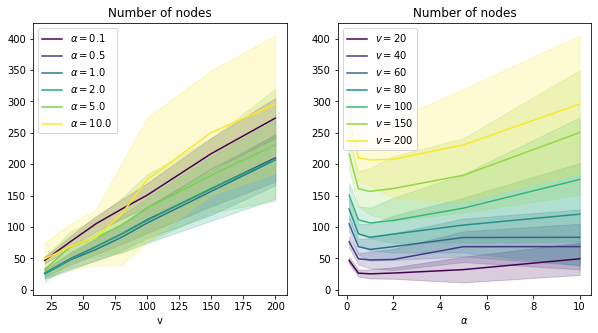

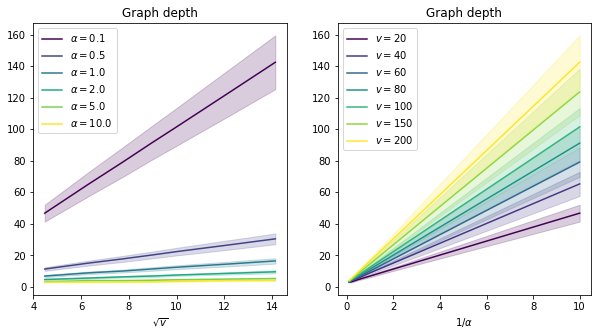

In [8]:
vs = [20,40,60,80,100, 150, 200]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10]
number_nodes = {}
depths = {}

xv, yv = np.meshgrid(vs, alphas)
for alpha in alphas:
    number_nodes[alpha] = {}
    depths[alpha] = {}
    for v in vs:
        number_nodes[alpha][v] = []
        depths[alpha][v] = []
        for k in range(20):
            G, widths, height = graph_dag_structure(v, alpha, k)
            depths[alpha][v].append(height)
            number_nodes[alpha][v].append(G.number_of_nodes())
            assert height == len(nx.dag_longest_path(G))

number_nodes_v = {}
depths_v = {}
for v in vs:
    number_nodes_v[v] = {}
    depths_v[v] = {}
    for alpha in alphas:
        number_nodes_v[v][alpha] = number_nodes[alpha][v]
        depths_v[v][alpha] = depths[alpha][v]


fig, ax = plt.subplots(1,2,figsize=(10, 5))
color=np.linspace(0, 1, len(alphas))
color2=np.linspace(0, 1, len(vs))

for i, alpha in enumerate(alphas):
    mean = np.array([np.mean(nn) for nn in number_nodes[alpha].values()])
    std = np.array([np.std(nn) for nn in number_nodes[alpha].values()])
    ax[0].plot(vs, mean, color=plt.cm.viridis(color[i]), label=r'$\alpha=$%.1f' %(alpha))
    ax[0].fill_between(vs, mean - std, mean+ std, color=plt.cm.viridis(color[i]), alpha=0.2)
    ax[0].set_title('Number of nodes')
    ax[0].set_xlabel('v')

for i, v in enumerate(vs):
    mean = np.array([np.mean(nn) for nn in number_nodes_v[v].values()])
    std = np.array([np.std(nn) for nn in number_nodes_v[v].values()])
    ax[1].plot(alphas, mean, color=plt.cm.viridis(color2[i]), label=r'$v=$%d' %(v))
    ax[1].fill_between(alphas, mean - std, mean+ std, color=plt.cm.viridis(color2[i]), alpha=0.2)
    ax[1].set_title('Number of nodes')
    ax[1].set_xlabel(r'$\alpha$')
    
ax[0].legend()
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10, 5))
for i, alpha in enumerate(alphas):
    mean = np.array([np.mean(nn) for nn in depths[alpha].values()])
    std = np.array([np.std(nn) for nn in depths[alpha].values()])
    ax[0].plot(np.sqrt(vs), mean, color=plt.cm.viridis(color[i]), label=r'$\alpha=$%.1f' %(alpha))
    ax[0].fill_between(np.sqrt(vs), mean - std, mean+ std, color=plt.cm.viridis(color[i]), alpha=0.2)
    ax[0].set_title('Graph depth')
    ax[0].set_xlabel(r'$\sqrt{v}$')
    
for i, v in enumerate(vs):
    mean = np.array([np.mean(nn) for nn in depths_v[v].values()])
    std = np.array([np.std(nn) for nn in depths_v[v].values()])
    ax[1].plot(1/np.array(alphas), mean, color=plt.cm.viridis(color2[i]), label=r'$v=$%d' %(v))
    ax[1].fill_between(1/np.array(alphas), mean - std, mean+ std, color=plt.cm.viridis(color2[i]), alpha=0.2)
    ax[1].set_title('Graph depth')
    ax[1].set_xlabel(r'$1/\alpha$')
    
ax[0].legend()
ax[1].legend()
plt.show()


In [80]:
vs = [20,40,60,80,100, 150, 200]
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10]
probs = [0.05, 0.1, 0.2, 0.5, 0.8, 1]
number_of_edges = {}
in_degree = {}
out_degree = {}
degree = {}
path_length = {}

for alpha in alphas:
    number_of_edges[alpha] = {}
    in_degree[alpha] = {}
    out_degree[alpha] = {}
    degree[alpha] = {}
    path_length[alpha] = {}
    for v in vs:
        number_of_edges[alpha][v] = {}
        in_degree[alpha][v] = {}
        out_degree[alpha][v] = {}
        degree[alpha][v] = {}
        path_length[alpha][v] = {}
        for p in probs:
            number_of_edges[alpha][v][p] = []
            in_degree[alpha][v][p] = []
            out_degree[alpha][v][p] = []
            degree[alpha][v][p] = []
            path_length[alpha][v][p] = []
            for k in range(10):
                G, widths, height = graph_dag_structure(v, alpha, k, p)
                number_of_edges[alpha][v][p].append(G.number_of_edges())
                in_degree[alpha][v][p].append([G.in_degree(a) for a in range(1, G.number_of_nodes()-1)])
                out_degree[alpha][v][p].append([G.out_degree(a) for a in range(1, G.number_of_nodes()-1)])
                degree[alpha][v][p].append([G.degree(a) for a in range(1, G.number_of_nodes()-1)])
#                 path_length[alpha][v][p].append([len(path) for path in nx.all_simple_paths(G, source=0, target=G.number_of_nodes()-1)])
                assert height == len(nx.dag_longest_path(G))

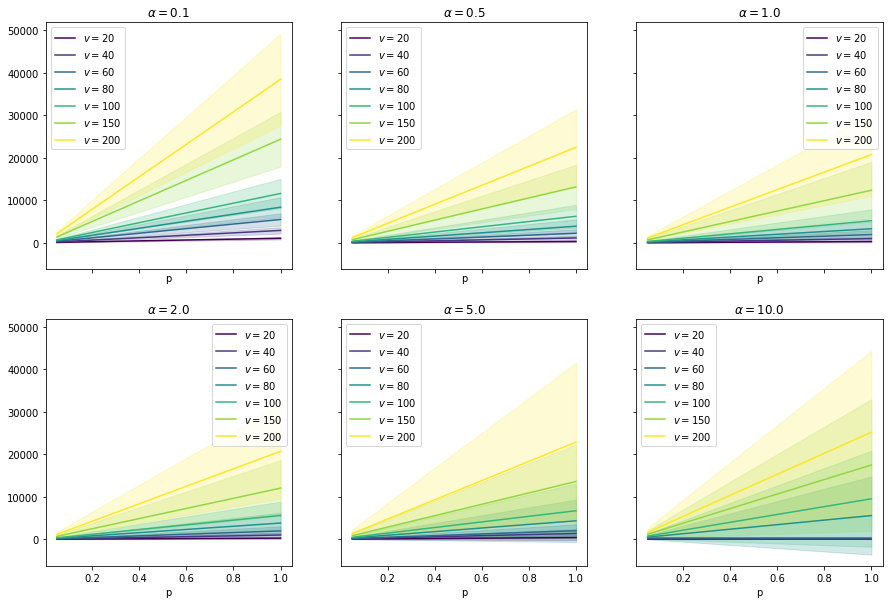

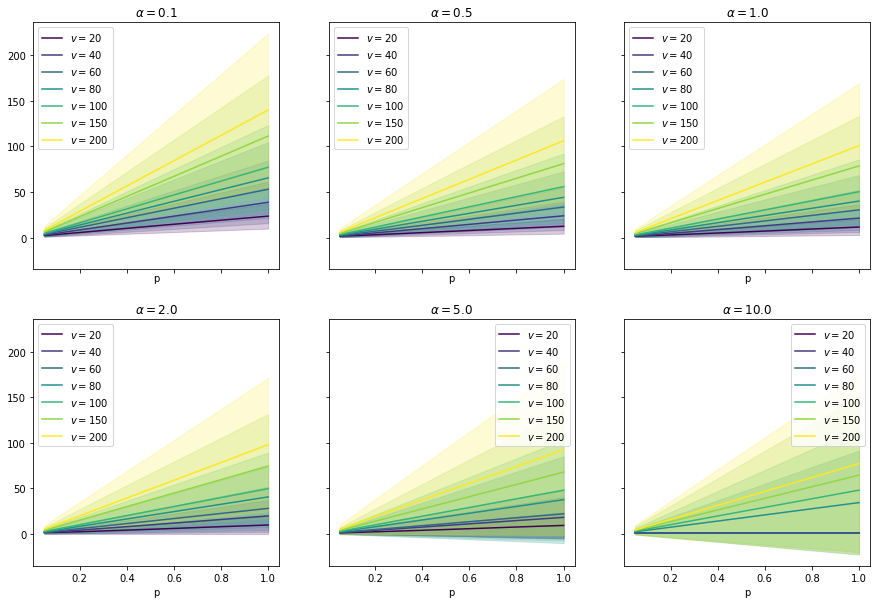

In [88]:
fig, ax = plt.subplots(2,len(alphas)//2 ,figsize=(len(alphas)//2 * 5, 10), sharex=True, sharey=True)
color=np.linspace(0, 1, len(vs))
for i, alpha in enumerate(alphas):
    y = i  % (len(alphas)//2)
    x = i  // (len(alphas)//2)
    for j, v in enumerate(vs):
        mean = np.array([np.mean(nn) for nn in number_of_edges[alpha][v].values()])
        std = np.array([np.std(nn) for nn in number_of_edges[alpha][v].values()])
        ax[x,y].plot(probs, mean, color=plt.cm.viridis(color[j]), label=r'$v=%d$' %(v))
        ax[x,y].fill_between(probs, mean - std, mean+ std, color=plt.cm.viridis(color[j]), alpha=0.2)
        ax[x,y].set_title(r'$\alpha=%.1f$' %(alpha))
        ax[x,y].set_xlabel('p')
    ax[x,y].legend()
    
    
fig, ax = plt.subplots(2,len(alphas)//2 ,figsize=(len(alphas)//2 * 5, 10), sharex=True, sharey=True)
for i, alpha in enumerate(alphas):
    y = i  % (len(alphas)//2)
    x = i  // (len(alphas)//2)
    for j, v in enumerate(vs):
        mean = np.array([np.mean([a for n in nn for a in n]) for nn in in_degree[alpha][v].values()])
        std = np.array([np.std([a for n in nn for a in n]) for nn in in_degree[alpha][v].values()])
        ax[x,y].plot(probs, mean, color=plt.cm.viridis(color[j]), label=r'$v=%d$' %(v))
        ax[x,y].fill_between(probs, mean - std, mean+ std, color=plt.cm.viridis(color[j]), alpha=0.2)
        ax[x,y].set_title(r'$\alpha=%.1f$' %(alpha))
        ax[x,y].set_xlabel('p')
    ax[x,y].legend()
    
plt.show()
